# 14 - Displaying Lithology Data Using Python and matplotlib
  
**Created By:** Andy McDonald  
**Link to Article:** https://andymcdonaldgeo.medium.com/displaying-lithology-data-using-python-and-matplotlib-58b4d251ee7a

Adding lithology information to a well log plot can enhance a petrophysical or geological interpretation. It can be used to understand why some log responses may behave the way they do. This data may have been sourced from a previous mineralogical interpretation or from mud logs.

In my previous article: Enhancing Visualization of Well Logs With Plot Fills, we saw: how to apply fixed color fill between a curve and the edge of a track, how to apply a density-neutron crossover fill and how to apply a variable fill based upon the value of curve being plotted. 

In this notebook, we will cover how to use a variable fill to apply not only a color to our plot, but also a hatching. Using these two options allows us to generate lithological fill.

This notebook forms part of my Python & Petrophysics series. The full series can be found here. For the examples below you can find my Jupyter Notebook and dataset on my GitHub repository at the following link.

## Setting up the Libraries 
The first step is to bring in the libraries we will be working with for this article. We will be using just two libraries: pandas and matplotlib. This will allow us to load our data to a dataframe and display it on a plot.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Loading the Data
The dataset we will be using for this article comes from a recent Machine Learning competition for lithology prediction that was run by Xeek and FORCE (https://xeek.ai/challenges/force-well-logs/overview). The objective of the competition was to predict lithology from a dataset consisting 98 training wells each with varying degrees of log completeness. The objective was to predict lithofacies based on the log measurements. To download the file, navigate to the Data section of the link above.

The data can be loaded using pd.read_csv(). As this is quite a large dataset, we will use a single well from it to work with and we will also take just the curves (columns) we need. We can do that by taking a subset of the data like so:

In [2]:
alldata = pd.read_csv('Data/xeek_train_subset.csv')

In [3]:
data = alldata.loc[alldata['WELL'] == '16/10-1'][['DEPTH_MD', 'GR', 'RHOB', 'NPHI', 'FORCE_2020_LITHOFACIES_LITHOLOGY']]

To make things simpler we will rename the FORCE_2020_LITHOFACIES_LITHOLOGY column to just LITHOLOGY . This is done by using the rename function on the dataframe and passing a dictionary of the old name and the new name. Note that using the `inplace=True` argument will replace the column name in the original dataframe.

In [4]:
data.rename(columns={'FORCE_2020_LITHOFACIES_LITHOLOGY':'LITHOLOGY'}, inplace=True)

When we call upon our dataframe using `data.head()` we can see that our dataset is small and our lithology column has been renamed.

In [5]:
data.head()

,DEPTH_MD,GR,RHOB,NPHI,LITHOLOGY
58694,439.41579,51.431892,NaN,NaN,65030
58695,439.56779,49.472492,NaN,NaN,65030
58696,439.71979,50.167278,NaN,NaN,65030
58697,439.87179,46.572552,NaN,NaN,65030
58698,440.02379,48.498447,NaN,NaN,65030


## Setting up the Lithologies Using a Nested Dictionary
The lithologies currently listed in the lithology column contain a series of numbers. We can map these in a nested dictionary where we have the full name of the lithology, a simplified number (if required for conversion), the hatch style, and the color of the fill.

The colors are based on the Kansas Geological Survey website. However, hatching symbols are limited in the default setup of matplotlib. In a future article, I will cover how to create custom hatches and lithologies.

In [6]:
data['LITHOLOGY'].nunique()

10

In [7]:
lithology_numbers = {30000: {'lith':'Sandstone', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
                 65030: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                 65000: {'lith':'Shale', 'lith_num':3, 'hatch':'--', 'color':'#bebebe'},
                 80000: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                 74000: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-/', 'color':'#8080ff'},
                 70000: {'lith':'Limestone', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
                 70032: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                 88000: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                 86000: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'', 'color':'#ff80ff'},
                 99000: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                 90000: {'lith':'Coal', 'lith_num':11, 'hatch':'', 'color':'black'},
                 93000: {'lith':'Basement', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

In [8]:
lithology_numbers[30000]['color']

'#ffff00'

We can quickly convert our nested dictionary to a pandas dataframe to make it easier for humans to read by using the from_dict function like so.

In [9]:
df_lith = pd.DataFrame.from_dict(lithology_numbers, orient='index')
df_lith.index.name = 'LITHOLOGY'
df_lith

,lith,lith_num,hatch,color
LITHOLOGY,,,,
30000,Sandstone,1,..,#ffff00
65030,Sandstone/Shale,2,-.,#ffe119
65000,Shale,3,--,#bebebe
80000,Marl,4,,#7cfc00
74000,Dolomite,5,-/,#8080ff
70000,Limestone,6,+,#80ffff
70032,Chalk,7,..,#80ffff
88000,Halite,8,x,#7ddfbe
86000,Anhydrite,9,,#ff80ff


By just looking at the dictionary, it can be difficult to understand how each of these will look. To solve this, we can quickly create a simple image showing the different hatchings and colors for each lithology. 
To do this, we will first define some co-ordinates for two new variables x and y. Then we will setup the matplotlib figure and axes using subplots:

`fig, axes = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, fig size=(10,5), subplot_kw={'xticks':[], 'yticks':[]})`

This allows us to define the size of the plot (4 columns by 3 rows), the figure size, and turning off the tick marks on both axes.
We then want to loop through the flattened axes and the nested dictionary to add the data and hatched color fills to each subplot. As we are dealing with a nested dictionary, we need to us square brackets multiple times [ ][ ] to go in two levels. The first level is the key, and the second level is the key of the nested dictionary. For example, to retrieve the color we can access it by typing in `lithology_numbers[30000]['color']`

This generates a nice looking legend that we can refer to later on. Notice that the lithology symbols do not 100% match the Kansas Geological Survey chart. We will see how to resolve this in a future article.

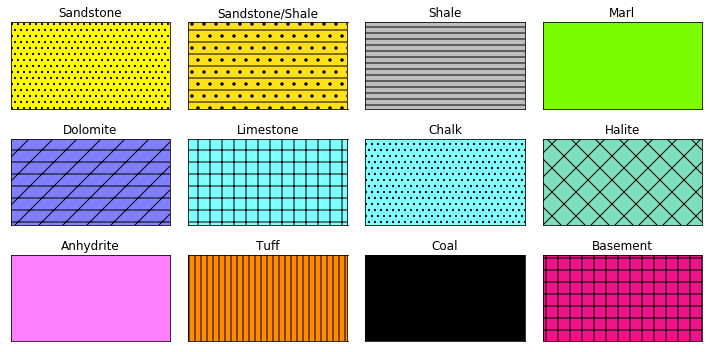

In [10]:
y = [0, 1]
x = [1, 1]

fig, axes = plt.subplots(ncols=4,nrows=3, sharex=True, sharey=True,
                         figsize=(10,5), subplot_kw={'xticks': [], 'yticks': []})

for ax, key in zip(axes.flat, lithology_numbers.keys()):
    ax.plot(x, y)
    ax.fill_betweenx(y, 0, 1, facecolor=lithology_numbers[key]['color'], hatch=lithology_numbers[key]['hatch'])
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 1)
    ax.set_title(str(lithology_numbers[key]['lith']))

plt.tight_layout()

plt.show()


## Setting up the Well Log Plot With a Lithology Track
In previous articles (Enhancing Visualization of Well Logs With Plot Fills and Exploratory Data Analysis With Well Log Data) I have set the plot up on the fly and passed in the dataframe I am working with. In this article, I will be creating a simple makeplot function which we can pass the dataframe into.

This allows us to easily reuse the code for other dataframes, assuming the curve names are the same. This could be further refined to make it more generic. This new function takes in three arguments, the dataframe, the top_depth, and the bottom depth.

This code will generate a well log plot with 3 tracks one for the Gamma Ray, one containing both Neutron Porosity and Bulk Density, and the final one containing our geological lithology data.

In [11]:
def makeplot(well, top_depth, bottom_depth):
    fig, ax = plt.subplots(figsize=(15,10))

    #Set up the plot axes
    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = ax2.twiny() #Twins the y-axis for the density track with the neutron track
    ax4 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax10 = ax1.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax2.twiny()
    ax11.xaxis.set_visible(False)
    ax13 = ax4.twiny()
    ax13.xaxis.set_visible(False)

    # Gamma Ray track
    ax1.plot(well["GR"], well['DEPTH_MD'], color = "green", linewidth = 0.5)
    ax1.set_xlabel("Gamma")
    ax1.xaxis.label.set_color("green")
    ax1.set_xlim(0, 200)
    ax1.set_ylabel("Depth (m)")
    ax1.tick_params(axis='x', colors="green")
    ax1.spines["top"].set_edgecolor("green")
    ax1.title.set_color('green')
    ax1.set_xticks([0, 50, 100, 150, 200])

    # Density track
    ax2.plot(well["RHOB"], well['DEPTH_MD'], color = "red", linewidth = 0.5)
    ax2.set_xlabel("Density")
    ax2.set_xlim(1.95, 2.95)
    ax2.xaxis.label.set_color("red")
    ax2.tick_params(axis='x', colors="red")
    ax2.spines["top"].set_edgecolor("red")
    ax2.set_xticks([1.95, 2.45, 2.95])

    # Neutron track placed ontop of density track
    ax3.plot(well["NPHI"], well['DEPTH_MD'], color = "blue", linewidth = 0.5)
    ax3.set_xlabel('Neutron')
    ax3.xaxis.label.set_color("blue")
    ax3.set_xlim(0.45, -0.15)
    ax3.tick_params(axis='x', colors="blue")
    ax3.spines["top"].set_position(("axes", 1.08))
    ax3.spines["top"].set_visible(True)
    ax3.spines["top"].set_edgecolor("blue")
    ax3.set_xticks([0.45,  0.15, -0.15])

    # Lithology track
    ax4.plot(well["LITHOLOGY"], well['DEPTH_MD'], color = "black", linewidth = 0.5)
    ax4.set_xlabel("Lithology")
    ax4.set_xlim(0, 1)
    ax4.xaxis.label.set_color("black")
    ax4.tick_params(axis='x', colors="black")
    ax4.spines["top"].set_edgecolor("black")

    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']
        ax4.fill_betweenx(well['DEPTH_MD'], 0, well['LITHOLOGY'], where=(well['LITHOLOGY']==key),
                         facecolor=color, hatch=hatch)
        

    ax4.set_xticks([0, 1])

    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax2, ax4]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
        
        
    for ax in [ax2, ax3, ax4]:
        plt.setp(ax.get_yticklabels(), visible = False)
        
    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)
    

The key piece of code to ensure our lithology `fill_betweenx` function from matplotlib creates a variable fill is shown below. All we are doing is looping over each of the keys within the dictionary, assigning simpler variable names to the features within the dictionary, and then using the `fill_betweenx()` function to check if the value in our lithology column equals the dictionary key. If it does, then it will apply the relevant color and hatching to the fill. It will then move on to the next key and repeat until all keys have been cycled through.

## Displaying the Well Log Plot & Lithology
Once we have the plot set up as a function. We can simply pass in our dataframe and the depths that we want to plot. In this example, we will focus on a small section of the data so that we are able to see the change in the plot fills.

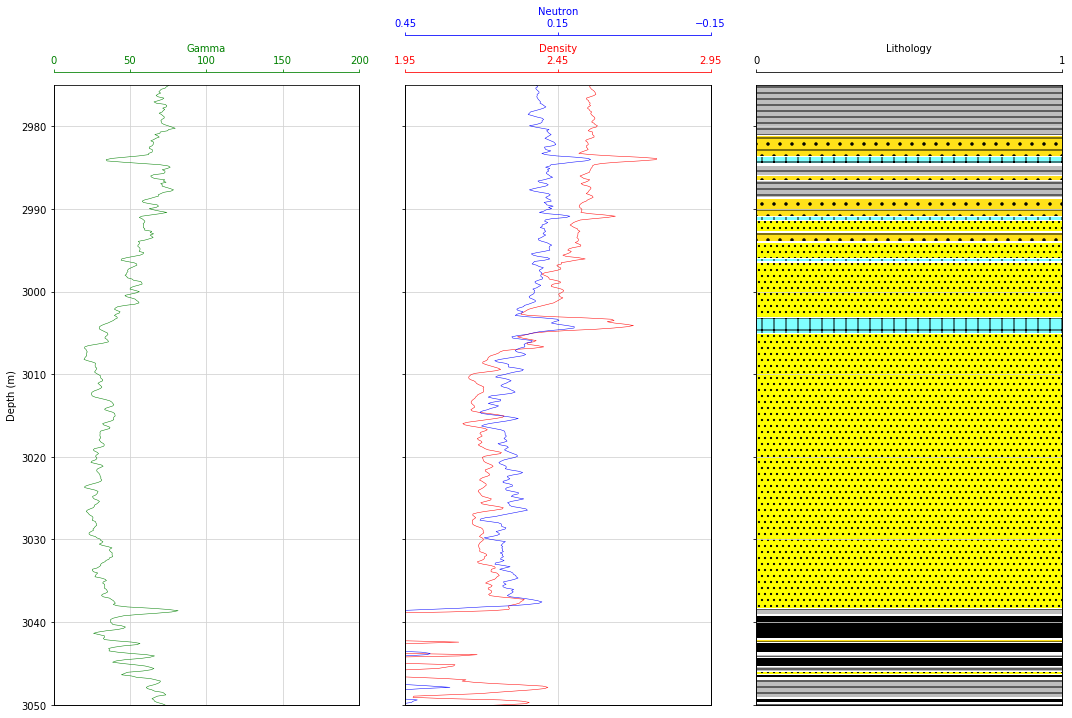

In [12]:
makeplot(data, 2975, 3050)

## Summary
In this article we have covered how to setup and display lithology data using matplotlib's fill_betweenx() function. We saw how a nested dictionary can be used to store parameters for each lithology and then be called upon using a for loop to fill with the correct color and hatch.
Adding this data to a plot can enhance how the geoscientist or petrophysicist relates the electrical logging measurements to the geology.

***Thanks for reading!***

If you have found this article useful, please feel free to check out my other articles looking at various aspects of Python and well log data. You can also find my code used in this article and others at GitHub.
If you want to get in touch you can find me on LinkedIn or at my website.
Interested in learning more about python and well log data or petrophysics? Follow me on Medium.
## References
Kansas Geological Survey, Lithology Symbols. http://www.kgs.ku.edu/PRS/Ozark/PROFILE/HELP/DATA_ENTRY/lithology/Lithology-Symbols.html

"Lithofacies data was provided by the FORCE Machine Learning competition with well logs and seismic 2020" Bormann P., Aursand P., Dilib F., Dischington P., Manral S. 2020. 2020 FORCE Machine Learning Contest. https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition